# Utilizing XResNet, it's ideas, and ImageWoof

In [ ]:
#Run once per session
!pip install fastai -q --upgrade

# Dataset:

Our dataset today will be ImageWoof. [Link](https://github.com/fastai/imagenette)

Goal: Using no pre-trained weights, see how well of accuracy we can get in x epochs

This dataset is generally harder than imagenette, both are a subset of ImageNet.

Models are leaning more towards being faster, more effecient

In [ ]:
from fastai.vision.all import *

Let's grab our data. For the competition, we'll focus on 5 epochs at 128x128

In [ ]:
path = untar_data(URLs.IMAGEWOOF)

There are a few more datasets available:

* ImageNette: Slightly easier than ImageWoof, 10 easily classified classes from Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute)

* ImageWoof: 10 different dog breeds, Australian terrier, Border terrier, Samoyed, Beagle, Shih-Tzu, English foxhound, Rhodesian ridgeback, Dingo, Golden retriever, Old English sheepdog

* Image网 (Pronounced Imagewang, "net" in Chinese): Both ImageNette and Woof but:
  * The validation set is the same as Imagewoof (i.e. 30% of Imagewoof images); there are no Imagenette images in the validation set (they're all in the training set)
  * Only 10% of Imagewoof images are in the training set!
  * The remaining are in the unsup ("unsupervised") directory, and you can not use their labels in training!

We'll use the low-level `Dataset` API for this.

In [ ]:
tfms = [[PILImage.create], [parent_label, Categorize()]]
item_tfms = [ToTensor(), Resize(128)]
batch_tfms = [FlipItem(), RandomResizedCrop(128, min_scale=0.35),
              IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

Let's make our split

In [ ]:
items = get_image_files(path)

In [ ]:
split_idx = GrandparentSplitter(valid_name='val')(items)

Now let's build our `DataSet`

In [ ]:
dsets = Datasets(items, tfms, splits=split_idx)

And our `DataLoaders`

In [ ]:
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64)

Let's make sure we look okay

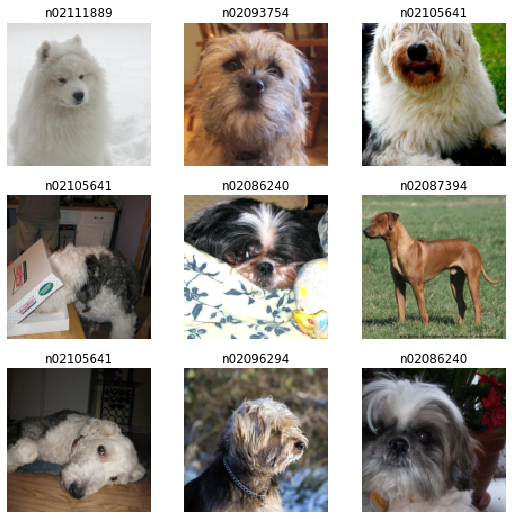

In [ ]:
dls.show_batch()

Wait, those aren't species names! How do I get that readable?

* We can use a dictionary as a transform on our `y`'s

In [ ]:
lbl_dict = dict(
  n02086240= 'Shih-Tzu',
  n02087394= 'Rhodesian ridgeback',
  n02088364= 'Beagle',
  n02089973= 'English foxhound',
  n02093754= 'Australian terrier',
  n02096294= 'Border terrier',
  n02099601= 'Golden retriever',
  n02105641= 'Old English sheepdog',
  n02111889= 'Samoyed',
  n02115641= 'Dingo'
)

To do so we pass in the `__getitem__` attribute to our transforms

In [ ]:
tfms = [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize()]]

In [ ]:
dsets = Datasets(items, tfms, splits=split_idx)

In [ ]:
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64)

Let's make sure it worked

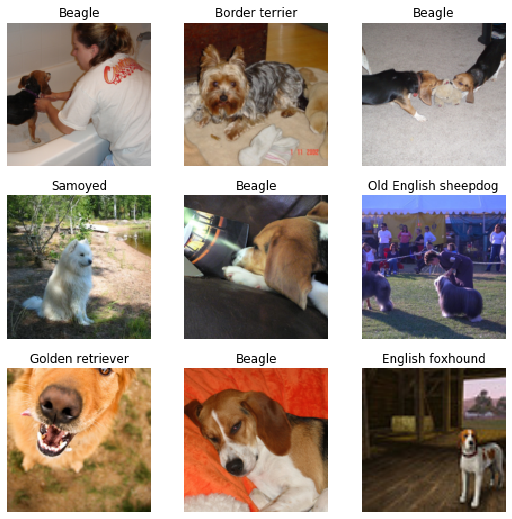

In [ ]:
dls.show_batch()

Much better!

# The Architecture and the new Implementations

* XResNet - Based on the [Bag of Tricks for Resnet](https://arxiv.org/abs/1812.01187) paper
* [Mish](https://arxiv.org/abs/1908.08681v1) - A new activation function that has shown fantastic results
* Ranger - A new optimizer function based on two seperate papers:
  * [On the Varience of the Adaptive Learning rate and Beyond, RAdam](https://arxiv.org/abs/1908.03265)
  * [Lookahead Optimizer: k steps forward, 1 step back](https://arxiv.org/abs/1907.08610)
* [Self-Attention](https://arxiv.org/abs/1805.08318) - Bringing in ideas from GAN's into image classification (Incorportated by Seb)
* [MaxBlurPool](https://arxiv.org/pdf/1904.11486) - Better generalization
* Flatten + Anneal Scheduling - Mikhail Grankin
* [Label Smoothing Cross Entropy](https://arxiv.org/abs/1906.11567) - A threshold base (were you close) rather than yes or no


All of these ideas live in the library (except Dialated Convolutions for now). But where? Let's walk through it

XResNet50:

In [ ]:
arch = xresnet50(pretrained=False)

After the `ImageWoof` competition, almost all of the above can simply be a setting in `xresnet`. 

## Mish:

In [ ]:
arch = xresnet50(pretrained=False, act_cls=Mish)

In [ ]:
arch[0]

ConvLayer(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Mish()
)

## Self-Attention:

In [ ]:
arch = xresnext50(pretrained=False, act_cls=Mish, sa=True)

## MaxBlurPool

In [ ]:
# Adopted from 
# https://discuss.pytorch.org/t/how-can-i-replace-an-intermediate-layer-in-a-pre-trained-network/3586/7
import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model

### Model

In [ ]:
net = xresnet50(pretrained=False, act_cls=Mish, sa=True, n_out=10)

In [ ]:
net = convert_MP_to_blurMP(net, nn.MaxPool2d)

Now that we know how to use it all, let's test it out!

# Ranger + Fit-Flat-Cosine

In [ ]:
opt_func = ranger

That is the same thing as:

In [ ]:
def opt_func(ps, lr=defaults.lr): return Lookahead(RAdam(ps, lr=lr))

In [ ]:
opt_func = opt_func

We'll also use Label Smoothing Cross Entropy as our loss

In [ ]:
learn = Learner(dls, model=net, loss_func=LabelSmoothingCrossEntropy(), metrics=[top_k_accuracy, accuracy])

Finally let's find and fit our model

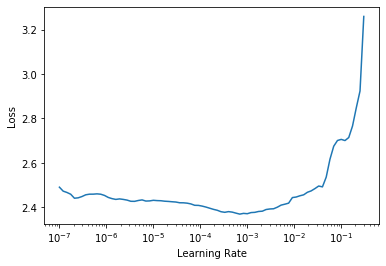

In [ ]:
learn.lr_find()

And fit for 5 epochs! We want to use `fit_flat_cos` that Mikahil Grankin came up with. Why?

* We noticed gradient blow up. So instead of One-Cycle:

## One-Cycle vs Fit-Flat-Cosine

In [ ]:
from fastai.test_utils import synth_learner

In [ ]:
synth = synth_learner()

In [ ]:
synth.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,21.347940,19.025780,00:00


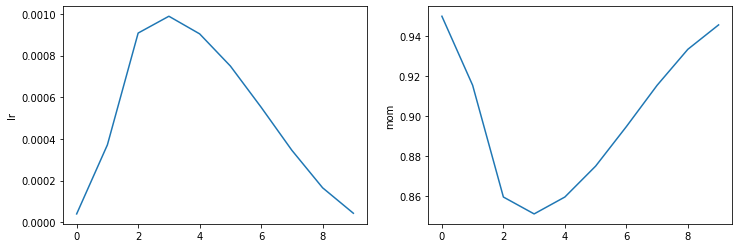

In [ ]:
synth.recorder.plot_sched()

We fit with Cosine Annealing:

In [ ]:
synth.fit_flat_cos(1, pct_start=0.72)

epoch,train_loss,valid_loss,time
0,10.726837,7.322753,00:00


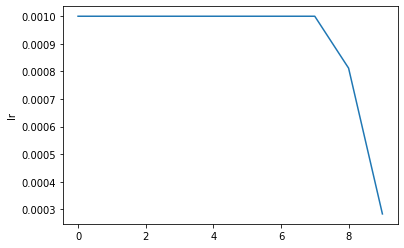

In [ ]:
synth.recorder.plot_sched()

# Let's Train!

In [ ]:
learn.fit_one_cycle(5, 4e-3)

epoch,train_loss,valid_loss,top_k_accuracy,accuracy,time
0,2.140411,3.043644,0.699160,0.240519,01:30
1,1.891249,2.547454,0.796640,0.279715,01:27
2,1.655039,1.859061,0.875286,0.396284,01:27
3,1.441251,1.423932,0.942734,0.599644,01:27
4,1.300972,1.316533,0.950624,0.649784,01:27
